In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
# from optimization_pyomo_flexible import ODEOptimizationModel
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

In [38]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [39]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 10, 2], penalty_lambda = 1000, max_iter = 500)
ode_model.build_model()
ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(t, u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.16\x3a Maximum Number of Iterations
      Exceeded.


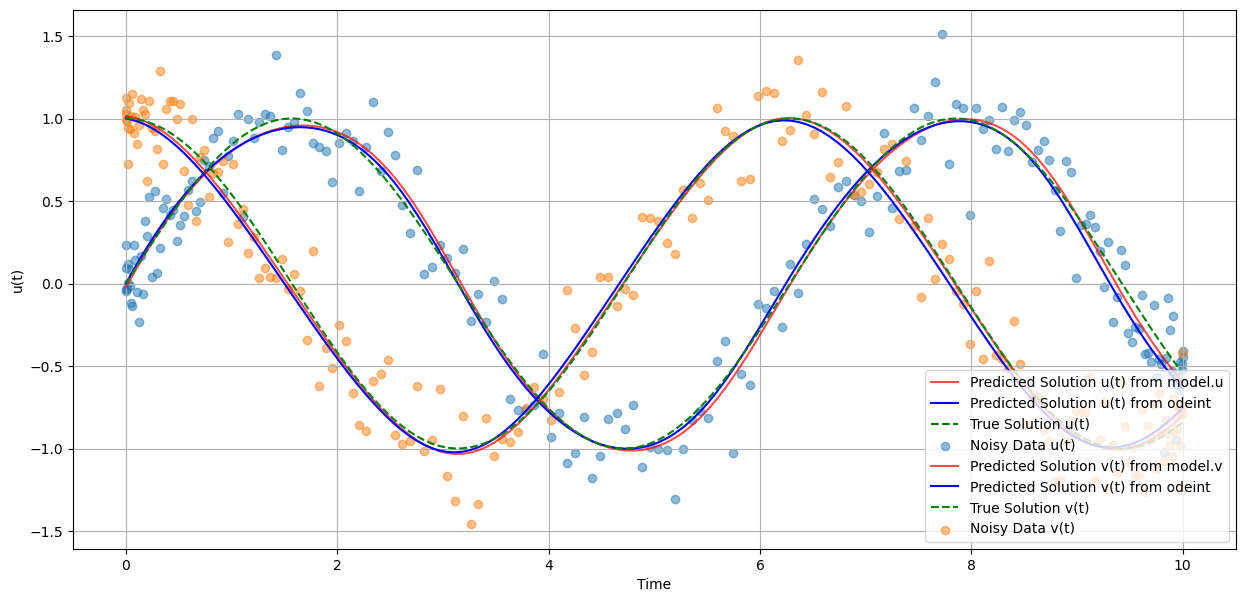

In [40]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [47]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
start_time, end_time = 0, 20
N = 100 + (end_time - 10)*10
#--------------------------------------------GENERATE DATA--------------------------------------------#
spacing_type = "equally_spaced"
t, y, y_noisy_, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
# numpy array is required for pyomo
t = np.array(jnp.squeeze(t))

solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

y_pred = jnp.vstack([u_odeint, v_odeint]).T

Abs Mean Error Train: 0.0351; Abs Mean Error Test: 0.5944


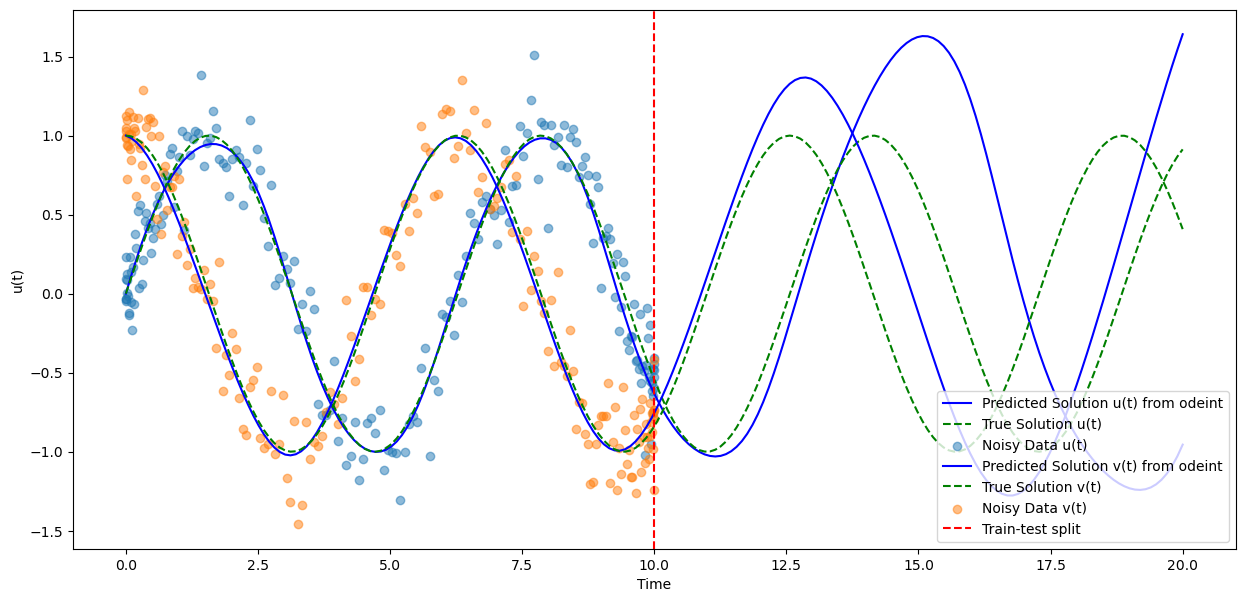

In [53]:
#-----------------------REGENERATE ORIGINAL DATA----------------------#
start_time, end_time = 0, 10
spacing_type = "chebyshev" 
t_original, _, y_noisy, _ = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

#----------------------------------MAE--------------------------------#
ame_train = jnp.mean(jnp.abs(y_pred[:100] - y[:100]))
ame_test = jnp.mean(jnp.abs(y_pred[100:] - y[100:]))
print(f'Abs Mean Error Train: {ame_train:.4f}; Abs Mean Error Test: {ame_test:.4f}')

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
# plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_original, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

# plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t_original, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
# plt.grid(True)
plt.show()